In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Helper functions to build backward context

In [2]:
def build_binary_ops_tensor(ts1, ts2, grad_fn_ts1, grad_fn_ts2, values):
    """for binary operator"""
    requires_grad = ts1.requires_grad or ts2.requires_grad
    dependency = []
    if ts1.requires_grad:
        dependency.append(dict(tensor=ts1, grad_fn=grad_fn_ts1))
    if ts2.requires_grad:
        dependency.append(dict(tensor=ts2, grad_fn=grad_fn_ts2))
    tensor_cls = ts1.__class__
    return tensor_cls(values, requires_grad, dependency)


def build_unary_ops_tensor(ts, grad_fn, values):
    """for unary operators"""
    requires_grad = ts.requires_grad
    dependency = []
    if ts.requires_grad:
        dependency.append(dict(tensor=ts, grad_fn=grad_fn))
    tensor_cls = ts.__class__
    return tensor_cls(values, requires_grad, dependency)

### Define Tensor class

- needs to define numerical operators
- store its dependent tensors 
- store gradient functions w.r.t its dependent tensors

In [3]:
def as_tensor(obj):
    if not isinstance(obj, Tensor):
        obj = Tensor(obj)
    return obj


class Tensor:
    
    def __init__(self, values, requires_grad=False, dependency=None):
        self._values = np.array(values)
        self.shape = self.values.shape
        
        self.grad = None
        if requires_grad:
            self.zero_grad()
        self.requires_grad = requires_grad
        
        if dependency is None:
            dependency = []
        self.dependency = dependency
            
    @property
    def values(self):
        return self._values
    
    @values.setter
    def values(self, new_values):
        self._values = np.array(new_values)
        self.grad = None
        
    def zero_grad(self):
        self.grad = np.zeros(self.shape)
        
    def __matmul__(self, other):
        """ self @ other """
        return _matmul(self, as_tensor(other))
        
    def __rmatmul__(self, other):
        """ other @ self """
        return _matmul(as_tensor(other), self)
    
    def __imatmul__(self, other):
        """ self @= other """
        self.values = self.values @ as_tensor(other).values
        return self
    
    def __add__(self, other):
        """ self + other """
        return _add(self, as_tensor(other))
    
    def __radd__(self, other):
        """ other + self """
        return _add(as_tensor(other), self)
    
    def __iadd__(self, other):
        """ self += other """
        self.values = self.values + as_tensor(other).values
        return self
       
    def __sub__(self, other):
        """ self - other """
        return _sub(self, as_tensor(other))
    
    def __rsub__(self, other):
        """ other - self """
        return _add(as_tensor(other), self)
    
    def __isub__(self, other):
        """ self -= other """
        self.values = self.values - as_tensor(other).values
        return self
        
    def __mul__(self, other):
        """ self * other """
        return _mul(self, as_tensor(other))
    
    def __rmul(self, other):
        """ other * self """
        return _mul(as_tensor(other), self)
    
    def __imul(self, other):
        """ self *= other """
        self.values = self.values * as_tensor(other).values
        return self
    
    def __neg__(self):
        """ -self """
        return _neg(self)
    
    def sum(self, axis=None):
        return _sum(self, axis=axis)
    
    
    def backward(self, grad=None):
        assert self.requires_grad, "Call backward() on a non-requires-grad tensor."
        grad = 1.0 if grad is None else grad
        grad = np.array(grad)

        # accumulate gradient
        self.grad += grad

        # propagate the gradient to its dependencies
        for dep in self.dependency:
            grad_for_dep = dep["grad_fn"](grad)
            dep["tensor"].backward(grad_for_dep)
            
            
def _matmul(ts1, ts2):
    values = ts1.values @ ts2.values

    # c = a @ b
    # D_c / D_a = grad @ b.T
    # D_c / D_b = a.T @ grad
    def grad_fn_ts1(grad):
        return grad @ ts2.values.T

    def grad_fn_ts2(grad):
        return ts1.values.T @ grad

    return build_binary_ops_tensor(
        ts1, ts2, grad_fn_ts1, grad_fn_ts2, values)


def _add(ts1, ts2):
    values = ts1.values + ts2.values

    # c = a + b
    # D_c / D_a = 1.0
    # D_c / D_b = 1.0
    def grad_fn_ts1(grad):
        # handle broadcasting (5, 3) + (3,) -> (5, 3)
        for _ in range(grad.ndim - ts1.values.ndim):
            grad = grad.sum(axis=0)
        # handle broadcasting (5, 3) + (1, 3) -> (5, 3)
        for i, dim in enumerate(ts1.shape):
            if dim == 1:
                grad = grad.sum(axis=i, keepdims=True)
        return grad

    def grad_fn_ts2(grad):
        for _ in range(grad.ndim - ts2.values.ndim):
            grad = grad.sum(axis=0)
        for i, dim in enumerate(ts2.shape):
            if dim == 1:
                grad = grad.sum(axis=i, keepdims=True)
        return grad

    return build_binary_ops_tensor(
        ts1, ts2, grad_fn_ts1, grad_fn_ts2, values)


def _sub(ts1, ts2):
    return ts1 + (-ts2)


def _mul(ts1, ts2):
    values = ts1.values * ts2.values

    # c = a * b
    # D_c / D_a = b
    # D_c / D_b = a
    def grad_fn_ts1(grad):
        grad = grad * ts2.values
        for _ in range(grad.ndim - ts1.values.ndim):
            grad = grad.sum(axis=0)
        for i, dim in enumerate(ts1.shape):
            if dim == 1:
                grad = grad.sum(axis=i, keepdims=True)
        return grad

    def grad_fn_ts2(grad):
        grad = grad * ts1.values
        for _ in range(grad.ndim - ts2.values.ndim):
            grad = grad.sum(axis=0)
        for i, dim in enumerate(ts2.shape):
            if dim == 1:
                grad = grad.sum(axis=i, keepdims=True)
        return grad

    return build_binary_ops_tensor(
        ts1, ts2, grad_fn_ts1, grad_fn_ts2, values)


def _neg(ts):
    values = -ts.values

    def grad_fn(grad):
        return -grad

    return build_unary_ops_tensor(ts, grad_fn, values)


def _sum(ts, axis):
    values = ts.values.sum(axis=axis)
    if axis is not None:
        repeat = ts.values.shape[axis]

    def grad_fn(grad):
        if axis is None:
            grad = grad * np.ones_like(ts.values)
        else:
            grad = np.expand_dims(grad, axis)
            grad = np.repeat(grad, repeat, axis)
        return grad

    return build_unary_ops_tensor(ts, grad_fn, values)


### Linear regression example

In [4]:
# training data
x = Tensor(np.random.normal(0, 1.0, (100, 3)))
coef = Tensor(np.random.randint(0, 10, (3,)))
y = x * coef - 3 

params = {
    "w": Tensor(np.random.normal(0, 1.0, (3, 3)), requires_grad=True),
    "b": Tensor(np.random.normal(0, 1.0, 3), requires_grad=True)
}

learng_rate = 3e-4
loss_list = []
for e in range(101):
    # set gradient to zero
    for param in params.values():
        param.zero_grad()
    
    # forward
    predicted = x @ params["w"] + params["b"]
    err = predicted - y
    loss = (err * err).sum()
    
    # backward automatically
    loss.backward()
    
    # updata parameters
    for param in params.values():
        param -= learng_rate * param.grad
        
    loss_list.append(loss.values)
    if e % 10 == 0:
        print("epoch-%i \tloss: %.4f" % (e, loss.values))

epoch-0 	loss: 12002.3536
epoch-10 	loss: 2967.2402
epoch-20 	loss: 759.4492
epoch-30 	loss: 201.3600
epoch-40 	loss: 55.2152
epoch-50 	loss: 15.6038
epoch-60 	loss: 4.5236
epoch-70 	loss: 1.3388
epoch-80 	loss: 0.4027
epoch-90 	loss: 0.1226
epoch-100 	loss: 0.0377


Text(0, 0.5, 'loss')

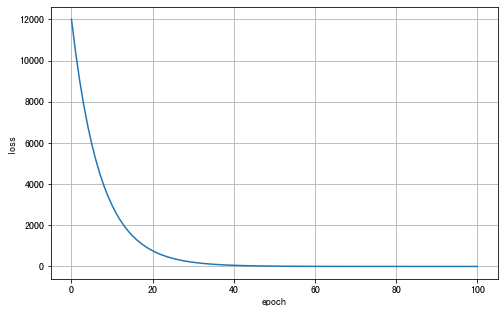

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(loss_list)
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")